In [1]:
!pip install darts

In [2]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [19]:
df = pd.read_csv('NFA.csv')
df=df.drop('min-temp',axis=1)
df

,location,ds,y
0,Adilabad,2020-11-12,32.70
1,Adilabad,2020-05-14,38.38
2,Adilabad,2022-12-31,35.05
3,Adilabad,2022-12-30,34.27
4,Adilabad,2022-12-29,34.63
...,...,...,...
1329,Adilabad,2019-01-05,34.63
1330,Adilabad,2019-01-04,34.60
1331,Adilabad,2019-01-03,35.28
1332,Adilabad,2019-01-02,32.10


In [20]:
df.describe()

,y
count,1334.00
mean,35.27
std,4.52
min,22.45
25%,32.51
50%,34.44
75%,37.94
max,46.79


In [21]:
'''from datetime import datetime 
from dateparser import parse
for i in range(len(df['ds'])+1):
    st=df['ds'][i]
    
    s=""
    for j in st:
        s+=j
    #date_time = parse(s)
    print(s)
    #cr_date=date_time.strftime("%d-%m-%Y")
    df['ds'][i] = datetime.datetime.strptime(s, '%Y-%m-%d')
'''
#df['ds'] = pd.to_datetime(df['ds'], format='%b-%d')
#print(df)
#df = df.set_index('Date')

'from datetime import datetime \nfrom dateparser import parse\nfor i in range(len(df[\'ds\'])+1):\n    st=df[\'ds\'][i]\n    \n    s=""\n    for j in st:\n        s+=j\n    #date_time = parse(s)\n    print(s)\n    #cr_date=date_time.strftime("%d-%m-%Y")\n    df[\'ds\'][i] = datetime.datetime.strptime(s, \'%Y-%m-%d\')\n'

In [22]:
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')

<AxesSubplot:xlabel='ds'>

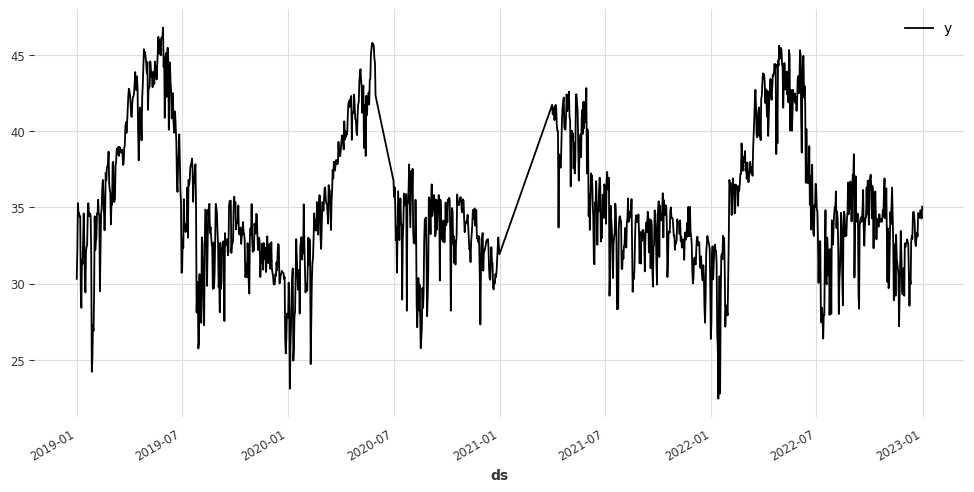

In [23]:
df.plot(x='ds', y='y', figsize=(12,6))

In [24]:
from darts import TimeSeries
from darts.models import ARIMA, AutoARIMA, ExponentialSmoothing, FFT, Theta, StatsForecastETS, StatsForecastAutoARIMA, Prophet, NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score, rmse, mae

filler = MissingValuesFiller()
scaler = Scaler()

In [25]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [26]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [11]:
#dec = sm.tsa.seasonal_decompose(df_Ka['AQI'],period = 12, model = 'multiplicative').plot()

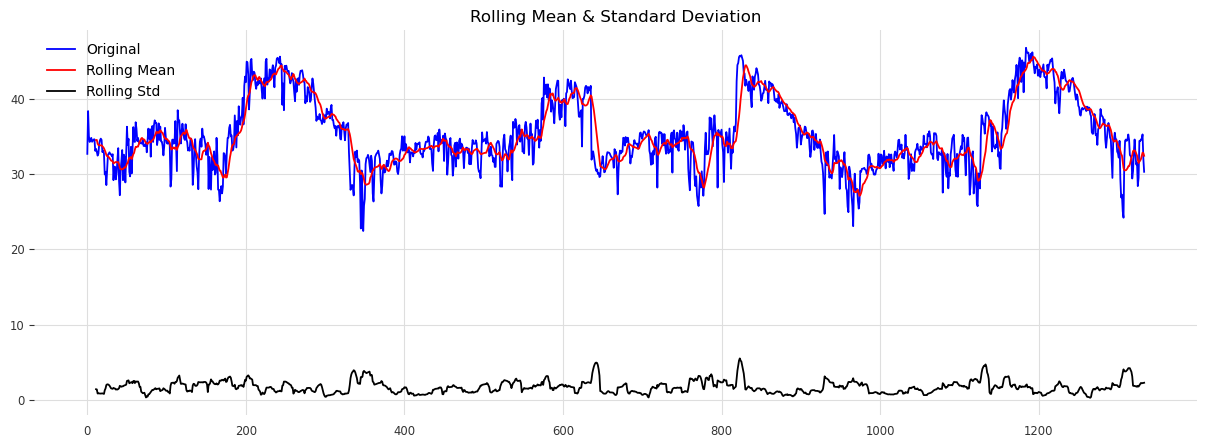

Results of Dickey-Fuller Test:
Test Statistic                  -3.13
p-value                          0.02
#Lags Used                      11.00
Number of Observations Used   1322.00
Critical Value (1%)             -3.44
Critical Value (5%)             -2.86
Critical Value (10%)            -2.57
dtype: float64


In [27]:
test_stationarity(df['y'])

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


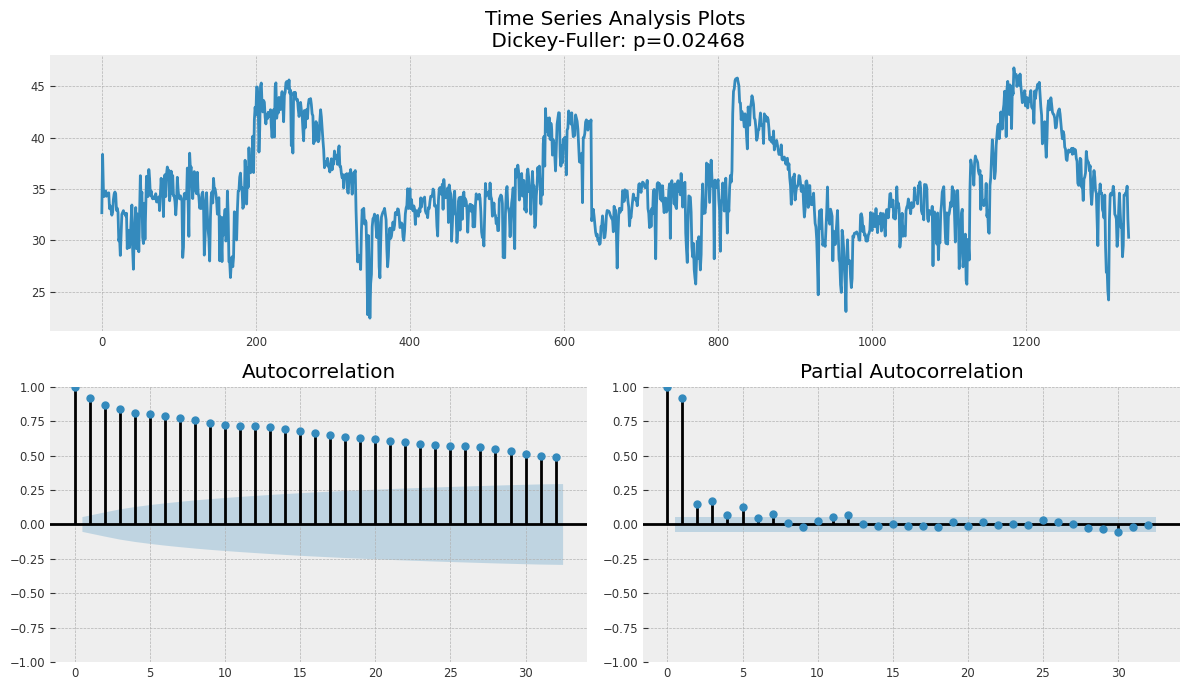

In [28]:
tsplot(df['y'])

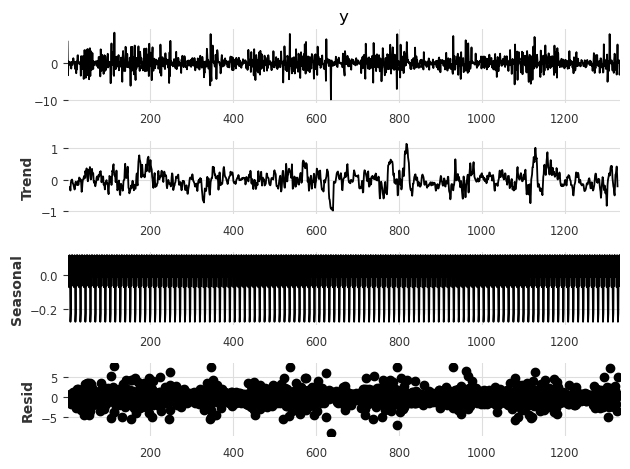

In [29]:
data_diff = df['y'].diff()
data_diff = data_diff.dropna()

dec = sm.tsa.seasonal_decompose(data_diff,period = 12).plot()
plt.show()

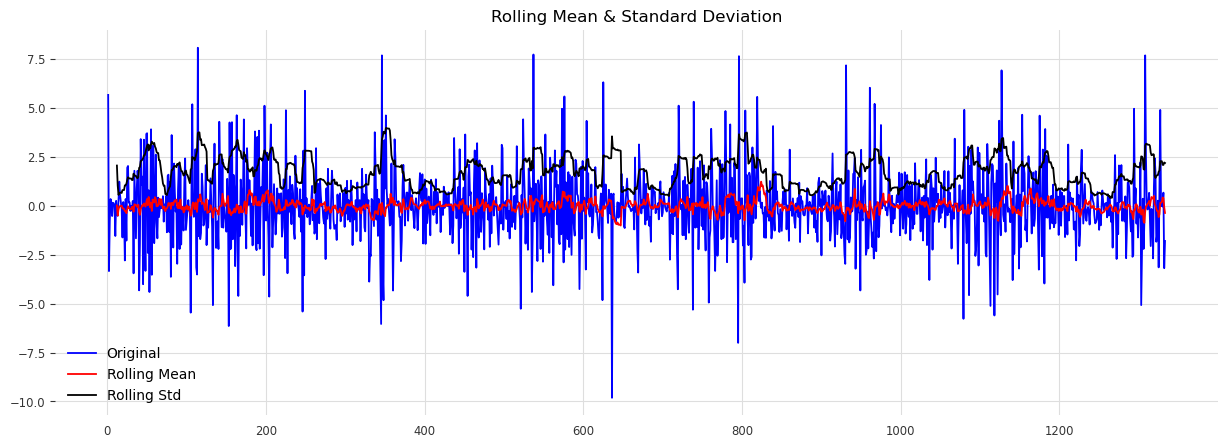

Results of Dickey-Fuller Test:
Test Statistic                 -14.87
p-value                          0.00
#Lags Used                      10.00
Number of Observations Used   1322.00
Critical Value (1%)             -3.44
Critical Value (5%)             -2.86
Critical Value (10%)            -2.57
dtype: float64


In [30]:
test_stationarity(data_diff)

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


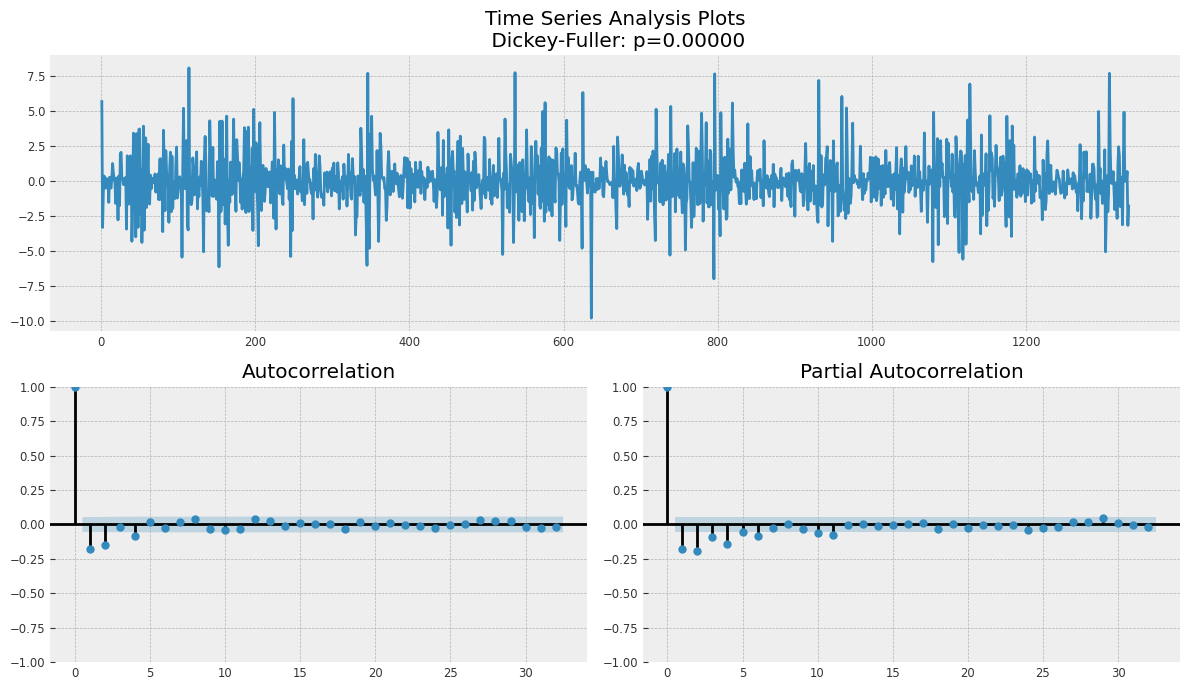

In [31]:
tsplot(data_diff)

In [36]:
series = TimeSeries.from_dataframe(df, 'ds',['y'],fill_missing_dates=True,freq=None)

ValueError: Could not find a unique inferred frequency (not constant). Observed frequencies: {'D', '2D'}. If any of those is the actual frequency, try passing it with fill_missing_dates=True and freq=your_frequency. For more information about frequency aliases, read https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases


ValueError: Could not find a unique inferred frequency (not constant). Observed frequencies: {'D', '2D'}. If any of those is the actual frequency, try passing it with fill_missing_dates=True and freq=your_frequency. For more information about frequency aliases, read https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1334 entries, 0 to 1333
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   location  1334 non-null   object        
 1   ds        1334 non-null   datetime64[ns]
 2   y         1334 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 31.4+ KB
